In [1]:
# Prerequisites
# ! pip install -U pandas
# ! pip install -U nltk  
# ! pip install -U gensim     
# ! pip install -U wordcloud
# ! python3 -m spacy download en_core_web_sm
# ! pip install -U pyLDAvis
# ! pip install -U keras
# ! pip install keras-self-attention

In [2]:
# Importing Libraries
import re
import numpy as np
import pandas as pd
from pprint import pprint

#NLTK libraries
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS

#vis
import pyLDAvis
import pyLDAvis.gensim_models

# Machine Learning libraries
import sklearn 
from sklearn.model_selection import train_test_split

#Metrics libraries
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#Deep learning libraries
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

2023-01-08 21:16:49.922874: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [3]:
# Loading Dataset
df=pd.read_csv('RAW_NEWS.csv')

# Temporarily using first 100 news only
# df = df[:200]
df.head()

,DateOfNews,Topic,LinkOfNews,HeadingOfNews,BodyOfNews
0,04/12/2022,national,https://www.dawn.com/news/1724594/qaiser-rues-...,Qaiser rues decision to grant extension to Baj...,ISLAMABAD: A week after retired Gen Qamar Jave...
1,04/12/2022,national,https://www.dawn.com/news/1724593/imran-couldv...,Imran could’ve ‘opted for suicide attack if tr...,QUETTA / PESHAWAR: As Pakistan Tehreek-i-Insaf...
2,04/12/2022,national,https://www.dawn.com/news/1724592/three-police...,Three police officials martyred in Nowshera gu...,PESHAWAR: Three policemen were martyred in an ...
3,04/12/2022,national,https://www.dawn.com/news/1724591/5-coal-miner...,5 coal miners killed in gas explosion in Harna...,QUETTA: At least five coal miners were killed ...
4,04/12/2022,national,https://www.dawn.com/news/1724590/sc-throws-ou...,SC throws out joint petition against perks of ...,ISLAMABAD: The Supreme Court on Saturday regre...


# PRE-PROCESSING DATA

In [4]:
# Cleansing the News heading by removing un-nessary words
df['HeadingOfNews'] = df['HeadingOfNews'].str.replace('\+|- DAWN.COM| Newspaper', '')

# Removing "Published in Dawn" from the end off news content
df['BodyOfNews'] = df['BodyOfNews'].str.split('Published in Dawn,').str[0]

# Comibining News Heading and Body
df['originalCombined'] = df['HeadingOfNews'] + ' ' + df['BodyOfNews']
df.head()

,DateOfNews,Topic,LinkOfNews,HeadingOfNews,BodyOfNews,originalCombined
0,04/12/2022,national,https://www.dawn.com/news/1724594/qaiser-rues-...,Qaiser rues decision to grant extension to Baj...,ISLAMABAD: A week after retired Gen Qamar Jave...,Qaiser rues decision to grant extension to Baj...
1,04/12/2022,national,https://www.dawn.com/news/1724593/imran-couldv...,Imran could’ve ‘opted for suicide attack if tr...,QUETTA / PESHAWAR: As Pakistan Tehreek-i-Insaf...,Imran could’ve ‘opted for suicide attack if tr...
2,04/12/2022,national,https://www.dawn.com/news/1724592/three-police...,Three police officials martyred in Nowshera gu...,PESHAWAR: Three policemen were martyred in an ...,Three police officials martyred in Nowshera gu...
3,04/12/2022,national,https://www.dawn.com/news/1724591/5-coal-miner...,5 coal miners killed in gas explosion in Harna...,QUETTA: At least five coal miners were killed ...,5 coal miners killed in gas explosion in Harna...
4,04/12/2022,national,https://www.dawn.com/news/1724590/sc-throws-ou...,SC throws out joint petition against perks of ...,ISLAMABAD: The Supreme Court on Saturday regre...,SC throws out joint petition against perks of ...


In [5]:
# download stopwords
nltk.download("stopwords")

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aniqurrahman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(df['originalCombined']))
data_words_body = list(sent_to_words(df['BodyOfNews']))
data_words_tittle = list(sent_to_words(df['HeadingOfNews']))

In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [8]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts):
    nlp = spacy.load("en_core_web_sm")
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc])
    return texts_out

In [9]:
def preprocess(text):
    # Remove Stop Words
    data_words_nostops = remove_stopwords(text)
    # Do Lemmatization
    data_lemmatized = lemmatization(data_words_nostops)
    # Form Bigrams
    data_words_bigrams = make_bigrams(data_lemmatized)
    # Form Trigrams
    data_words_trigrams = make_trigrams(data_words_bigrams)
    
    return data_words_trigrams

In [10]:
data_preprocessed = preprocess(data_words)
df['clean'] = data_preprocessed

df.head()

,DateOfNews,Topic,LinkOfNews,HeadingOfNews,BodyOfNews,originalCombined,clean
0,04/12/2022,national,https://www.dawn.com/news/1724594/qaiser-rues-...,Qaiser rues decision to grant extension to Baj...,ISLAMABAD: A week after retired Gen Qamar Jave...,Qaiser rues decision to grant extension to Baj...,"[qaiser, rue, decision, grant, extension, bajw..."
1,04/12/2022,national,https://www.dawn.com/news/1724593/imran-couldv...,Imran could’ve ‘opted for suicide attack if tr...,QUETTA / PESHAWAR: As Pakistan Tehreek-i-Insaf...,Imran could’ve ‘opted for suicide attack if tr...,"[imran, could, opted, suicide_attack, treat, l..."
2,04/12/2022,national,https://www.dawn.com/news/1724592/three-police...,Three police officials martyred in Nowshera gu...,PESHAWAR: Three policemen were martyred in an ...,Three police officials martyred in Nowshera gu...,"[three, police, official, martyr, nowshera, gu..."
3,04/12/2022,national,https://www.dawn.com/news/1724591/5-coal-miner...,5 coal miners killed in gas explosion in Harna...,QUETTA: At least five coal miners were killed ...,5 coal miners killed in gas explosion in Harna...,"[coal, miner, kill, gas, explosion, harnai, pa..."
4,04/12/2022,national,https://www.dawn.com/news/1724590/sc-throws-ou...,SC throws out joint petition against perks of ...,ISLAMABAD: The Supreme Court on Saturday regre...,SC throws out joint petition against perks of ...,"[sc, throw, joint, petition, perk, kp, teacher..."


In [11]:
df['title_clean'] = preprocess(data_words_tittle)
df['body_clean'] = preprocess(data_words_body)

In [12]:
df['body_clean_joined'] = df['body_clean'].apply(lambda x: " ".join(x))
df['title_clean_joined'] = df['title_clean'].apply(lambda x: " ".join(x))

In [13]:
df.head()

,DateOfNews,Topic,LinkOfNews,HeadingOfNews,BodyOfNews,originalCombined,clean,title_clean,body_clean,body_clean_joined,title_clean_joined
0,04/12/2022,national,https://www.dawn.com/news/1724594/qaiser-rues-...,Qaiser rues decision to grant extension to Baj...,ISLAMABAD: A week after retired Gen Qamar Jave...,Qaiser rues decision to grant extension to Baj...,"[qaiser, rue, decision, grant, extension, bajw...","[qaiser, rue, decision, grant, extension, bajwa]","[islamabad, week, retire, gen_qamar_javed_bajw...",islamabad week retire gen_qamar_javed_bajwa co...,qaiser rue decision grant extension bajwa
1,04/12/2022,national,https://www.dawn.com/news/1724593/imran-couldv...,Imran could’ve ‘opted for suicide attack if tr...,QUETTA / PESHAWAR: As Pakistan Tehreek-i-Insaf...,Imran could’ve ‘opted for suicide attack if tr...,"[imran, could, opted, suicide_attack, treat, l...","[imran, could, opted, suicide_attack, treat, l...","[quetta, peshawar, pakistan_tehreek_insaf, sen...",quetta peshawar pakistan_tehreek_insaf senator...,imran could opted suicide_attack treat like swati
2,04/12/2022,national,https://www.dawn.com/news/1724592/three-police...,Three police officials martyred in Nowshera gu...,PESHAWAR: Three policemen were martyred in an ...,Three police officials martyred in Nowshera gu...,"[three, police, official, martyr, nowshera, gu...","[three, police, official, martyr, nowshera, gu...","[peshawar, three, policeman, martyr, attack, a...",peshawar three policeman martyr attack akora k...,three police official martyr nowshera gun attack
3,04/12/2022,national,https://www.dawn.com/news/1724591/5-coal-miner...,5 coal miners killed in gas explosion in Harna...,QUETTA: At least five coal miners were killed ...,5 coal miners killed in gas explosion in Harna...,"[coal, miner, kill, gas, explosion, harnai, pa...","[coal, miner, kill, gas, explosion, harnai, pa...","[quetta, least, five, coal, miner, kill, gas, ...",quetta least five coal miner kill gas explosio...,coal miner kill gas explosion harnai pakistan
4,04/12/2022,national,https://www.dawn.com/news/1724590/sc-throws-ou...,SC throws out joint petition against perks of ...,ISLAMABAD: The Supreme Court on Saturday regre...,SC throws out joint petition against perks of ...,"[sc, throw, joint, petition, perk, kp, teacher...","[sc, throw, joint, petition, perk, kp, teacher...","[islamabad, supreme_court, saturday, regret, t...",islamabad supreme_court saturday regret treatm...,sc throw joint petition perk kp teacher pakistan


# VISUALIZE CLEANED UP DATASET

In [14]:
# Obtain the total words present in the dataset
list_of_words = []
for i in df.clean:
    for j in i:
        list_of_words.append(j)

print("Word Count Total:", len(list_of_words))
# Obtain the total number of unique words
print("Word Count Unique:", len(list(set(list_of_words))))

Word Count Total: 627825
Word Count Unique: 27754


<AxesSubplot: xlabel='count', ylabel='Topic'>

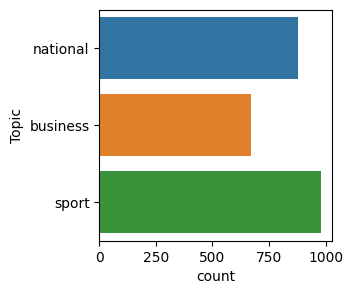

In [15]:
# plot the number of samples in 'HeadingOfNews'
plt.figure(figsize = (3, 3))
sns.countplot(y = "Topic", data = df)

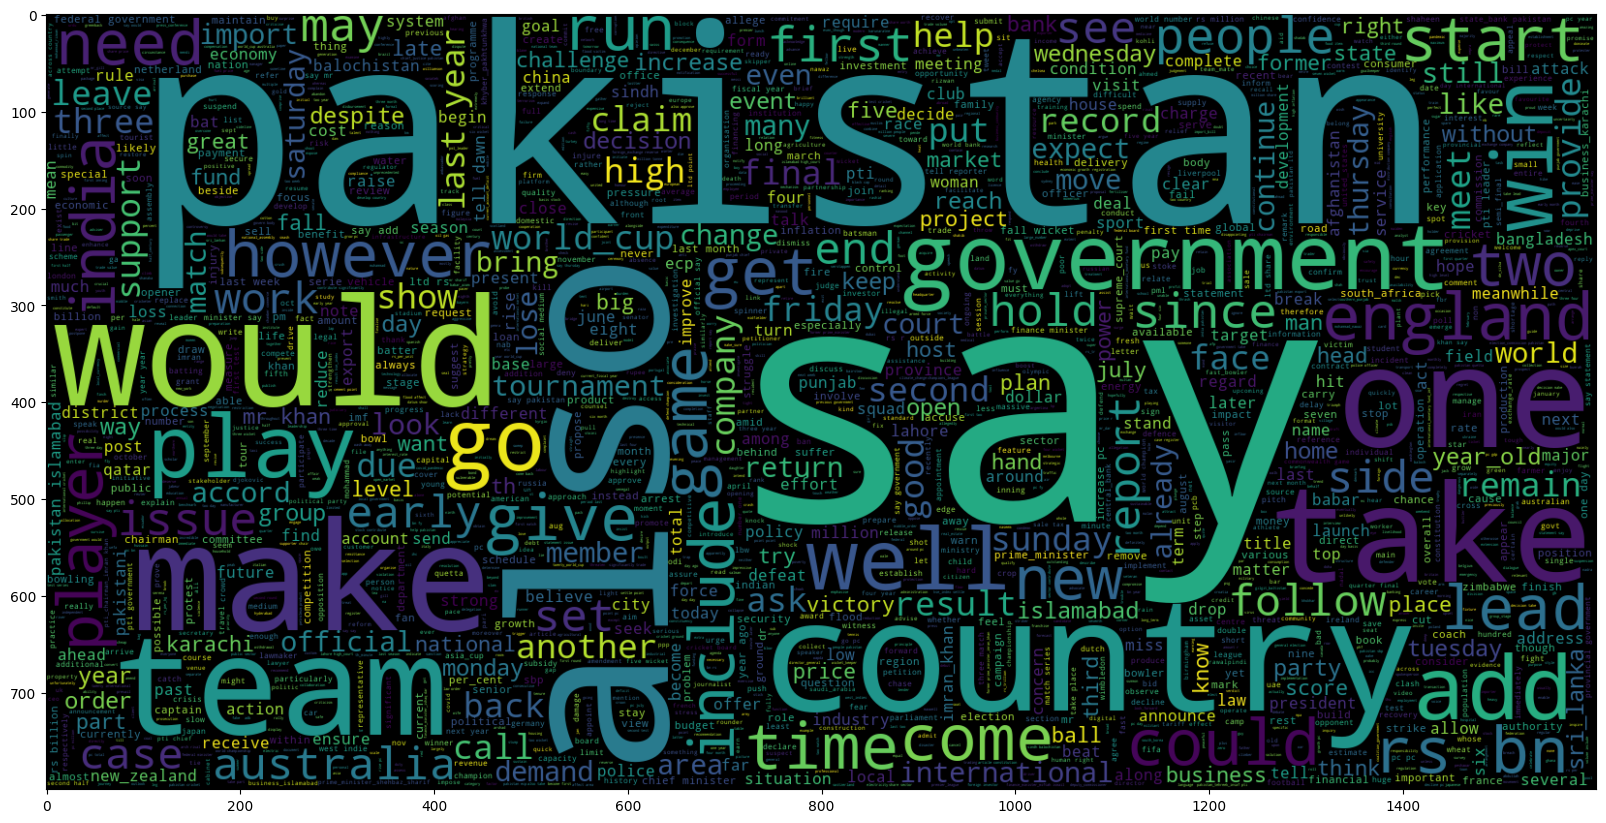

In [16]:
# join the words into a string
df['clean_joined'] = df['clean'].apply(lambda x: " ".join(x))
# plot the word cloud for text that is Real
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df.clean_joined))
plt.imshow(wc, interpolation = 'bilinear')

In [17]:
# length of maximum document will be needed to create word embeddings 
max_doc_len = -1
for doc in df.clean_joined:
    tokens = nltk.word_tokenize(doc)
    if(max_doc_len<len(tokens)):
        max_doc_len = len(tokens)
print("The maximum number of words in any document is =", max_doc_len)

The maximum number of words in any document is = 779


# FEATURE EMBEDDING USING BAG OF WORDS

In [18]:
id2word = corpora.Dictionary(data_preprocessed)

bow_corpus = []
for text in data_preprocessed:
    new = id2word.doc2bow(text)
    bow_corpus.append(new)

# print ("BOW News1:\n",bow_corpus[0])
# firstword = id2word[[0][:1][0]]
# print (firstword)

df['BOW'] = bow_corpus

df.head()


,DateOfNews,Topic,LinkOfNews,HeadingOfNews,BodyOfNews,originalCombined,clean,title_clean,body_clean,body_clean_joined,title_clean_joined,clean_joined,BOW
0,04/12/2022,national,https://www.dawn.com/news/1724594/qaiser-rues-...,Qaiser rues decision to grant extension to Baj...,ISLAMABAD: A week after retired Gen Qamar Jave...,Qaiser rues decision to grant extension to Baj...,"[qaiser, rue, decision, grant, extension, bajw...","[qaiser, rue, decision, grant, extension, bajwa]","[islamabad, week, retire, gen_qamar_javed_bajw...",islamabad week retire gen_qamar_javed_bajwa co...,qaiser rue decision grant extension bajwa,qaiser rue decision grant extension bajwa isla...,"[(0, 4), (1, 3), (2, 1), (3, 2), (4, 1), (5, 1..."
1,04/12/2022,national,https://www.dawn.com/news/1724593/imran-couldv...,Imran could’ve ‘opted for suicide attack if tr...,QUETTA / PESHAWAR: As Pakistan Tehreek-i-Insaf...,Imran could’ve ‘opted for suicide attack if tr...,"[imran, could, opted, suicide_attack, treat, l...","[imran, could, opted, suicide_attack, treat, l...","[quetta, peshawar, pakistan_tehreek_insaf, sen...",quetta peshawar pakistan_tehreek_insaf senator...,imran could opted suicide_attack treat like swati,imran could opted suicide_attack treat like sw...,"[(6, 1), (9, 1), (28, 2), (40, 1), (48, 1), (5..."
2,04/12/2022,national,https://www.dawn.com/news/1724592/three-police...,Three police officials martyred in Nowshera gu...,PESHAWAR: Three policemen were martyred in an ...,Three police officials martyred in Nowshera gu...,"[three, police, official, martyr, nowshera, gu...","[three, police, official, martyr, nowshera, gu...","[peshawar, three, policeman, martyr, attack, a...",peshawar three policeman martyr attack akora k...,three police official martyr nowshera gun attack,three police official martyr nowshera gun atta...,"[(0, 1), (6, 1), (9, 2), (12, 2), (33, 1), (46..."
3,04/12/2022,national,https://www.dawn.com/news/1724591/5-coal-miner...,5 coal miners killed in gas explosion in Harna...,QUETTA: At least five coal miners were killed ...,5 coal miners killed in gas explosion in Harna...,"[coal, miner, kill, gas, explosion, harnai, pa...","[coal, miner, kill, gas, explosion, harnai, pa...","[quetta, least, five, coal, miner, kill, gas, ...",quetta least five coal miner kill gas explosio...,coal miner kill gas explosion harnai pakistan,coal miner kill gas explosion harnai pakistan ...,"[(0, 2), (9, 1), (12, 1), (27, 1), (44, 1), (8..."
4,04/12/2022,national,https://www.dawn.com/news/1724590/sc-throws-ou...,SC throws out joint petition against perks of ...,ISLAMABAD: The Supreme Court on Saturday regre...,SC throws out joint petition against perks of ...,"[sc, throw, joint, petition, perk, kp, teacher...","[sc, throw, joint, petition, perk, kp, teacher...","[islamabad, supreme_court, saturday, regret, t...",islamabad supreme_court saturday regret treatm...,sc throw joint petition perk kp teacher pakistan,sc throw joint petition perk kp teacher pakist...,"[(9, 1), (27, 1), (33, 3), (40, 1), (49, 2), (..."


# LDA TOPIC MODELLING

In [19]:
TOPIC_COUNT = 3

lda_model = gensim.models.ldamodel.LdaModel(corpus=bow_corpus,
                                           id2word=id2word,
                                           num_topics=TOPIC_COUNT,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")


In [20]:

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, id2word, mds="mmds", R=30)
vis


/usr/local/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/local/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/local/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/local/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.094783  0.206072       1        1  35.703730
0      0.102502 -0.167329       2        1  33.983906
2     -0.197284 -0.038743       3        1  30.312364, topic_info=         Term         Freq        Total Category  logprob  loglift
810        pc  2838.000000  2838.000000  Default  30.0000  30.0000
643        rs  2417.000000  2417.000000  Default  29.0000  29.0000
876        bn  1630.000000  1630.000000  Default  28.0000  28.0000
67        pti  1785.000000  1785.000000  Default  27.0000  27.0000
781  increase  1365.000000  1365.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
196      also   899.149360  2943.201769   Topic3  -5.3550   0.0078
877    budget   542.169049   657.163746   Topic3  -5.8608   1.0013
97      would   637.686128  2158.259219   Topic3  -5.6986  -0.0256
147      last   593.618075  1961.944679   Topic3  -5.7702  -0.0018
217       day   577.645368  1916.424090   Topic3  -5.7974  -0.0056

[221 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         1  0.259456       add
0         2  0.489743       add
0         3  0.251012       add
195       2  0.998892    allege
196       1  0.217450      also
...     ...       ...       ...
99        1  0.352716      year
99        2  0.088547      year
99        3  0.558933      year
191       1  0.977100  year_old
191       2  0.023566  year_old

[313 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

## TEXT SUMMARIZATION

In [21]:
pre = pd.DataFrame()
pre['cleaned_text'] = df['body_clean_joined']
pre['cleaned_summary'] = df['title_clean_joined']


In [22]:
text_count = []
summary_count = []

In [23]:
for sent in pre['cleaned_text']:
    text_count.append(len(sent.split()))
for sent in pre['cleaned_summary']:
    summary_count.append(len(sent.split()))

In [24]:
graph_df= pd.DataFrame()
graph_df['text']=text_count
graph_df['summary']=summary_count

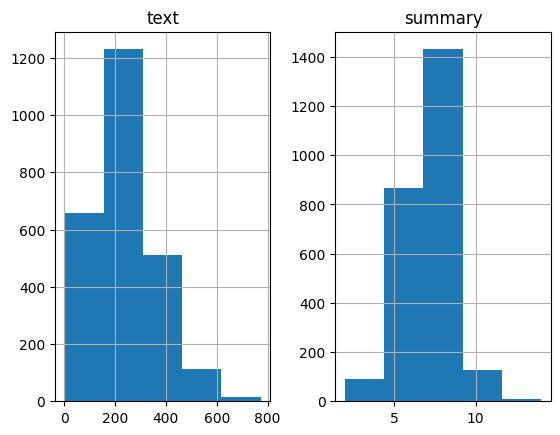

In [25]:
import matplotlib.pyplot as plt

graph_df.hist(bins = 5)
plt.show()

In [26]:
#Check how much % of summary have 0-15 words
cnt=0
for i in pre['cleaned_summary']:
    if(len(i.split())<=12):
        cnt=cnt+1
print(cnt/len(pre['cleaned_summary']))

0.998812821527503


In [27]:
#Check how much % of text have 0-70 words
cnt=0
for i in pre['cleaned_text']:
    if(len(i.split())<=600):
        cnt=cnt+1
print(cnt/len(pre['cleaned_text']))

0.9912940245350218


In [28]:
#Model to summarize the text between 0-15 words for Summary and 0-100 words for Text
max_text_len=600
max_summary_len=12

In [29]:
#Select the Summaries and Text between max len defined above

cleaned_text =np.array(pre['cleaned_text'])
cleaned_summary=np.array(pre['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
post_pre=pd.DataFrame({'text':short_text,'summary':short_summary})

In [30]:
post_pre

,text,summary
0,islamabad week retire gen_qamar_javed_bajwa co...,qaiser rue decision grant extension bajwa
1,quetta peshawar pakistan_tehreek_insaf senator...,imran could opted suicide_attack treat like swati
2,peshawar three policeman martyr attack akora k...,three police official martyr nowshera gun attack
3,quetta least five coal miner kill gas explosio...,coal miner kill gas explosion harnai pakistan
4,islamabad supreme_court saturday regret treatm...,sc throw joint petition perk kp teacher pakistan
...,...,...
2497,karachi stock_market witness another range bin...,stock drift low economic concern business
2498,london rights group amnesty international thur...,right group urge fifa pay qatar abuse migrant ...
2499,lahore dha lahore national inter depart mental...,inter departmental boxing saturday
2500,karachi fifa_world_cup trophy tour come pakist...,fifa remain silent normalisation process stall...


In [31]:
#Add sostok and eostok at 
post_pre['summary'] = post_pre['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [32]:
post_pre.head(2)

,text,summary
0,islamabad week retire gen_qamar_javed_bajwa co...,sostok qaiser rue decision grant extension baj...
1,quetta peshawar pakistan_tehreek_insaf senator...,sostok imran could opted suicide_attack treat ...


## SEQ2SEQ MODEL BUILDING

In [33]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(post_pre['text']),np.array(post_pre['summary']),test_size=0.1,random_state=0,shuffle=True)

In [34]:
#Lets tokenize the text to get the vocab count , you can use Spacy here also

from keras_preprocessing.text import Tokenizer 
from keras_preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [35]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 58.4914163969353
Total Coverage of rare words: 3.7900598928233684


In [36]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 10132


In [37]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [38]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 85.15943418844401
Total Coverage of rare words: 28.892032060348892


In [39]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 620


In [40]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [41]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [42]:
from keras import backend as K 
import gensim
from numpy import *
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras_preprocessing.text import Tokenizer 
from keras_preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

print("Size of vocabulary from the w2v model = {}".format(x_voc))

K.clear_session()

latent_dim = 300
embedding_dim=200

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Size of vocabulary from the w2v model = 10132


2023-01-08 21:22:50.115530: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 600)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 600, 200)     2026400     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 600, 300),   601200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

In [43]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [44]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

Start fitting the model with the data

In [45]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50


In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")